In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
yf.pdr_override()

In [4]:
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

In [5]:
stock = yf.download('GOOG',start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-26,52.299999,52.781502,50.419998,52.660500,52.660500,53302000
2018-03-27,53.150002,53.241951,49.846001,50.255001,50.255001,61906000
2018-03-28,49.900002,51.211498,49.032001,50.228001,50.228001,67386000
2018-03-29,50.581501,52.150002,50.145000,51.589500,51.589500,54536000
2018-04-02,51.140999,51.740002,49.518501,50.323502,50.323502,53608000
...,...,...,...,...,...,...
2023-03-20,101.059998,102.580002,100.790001,101.930000,101.930000,26033900
2023-03-21,101.980003,105.959999,101.860001,105.839996,105.839996,33122800
2023-03-22,105.139999,107.510002,104.209999,104.220001,104.220001,32336900


**Closing Price For Google's Stock**

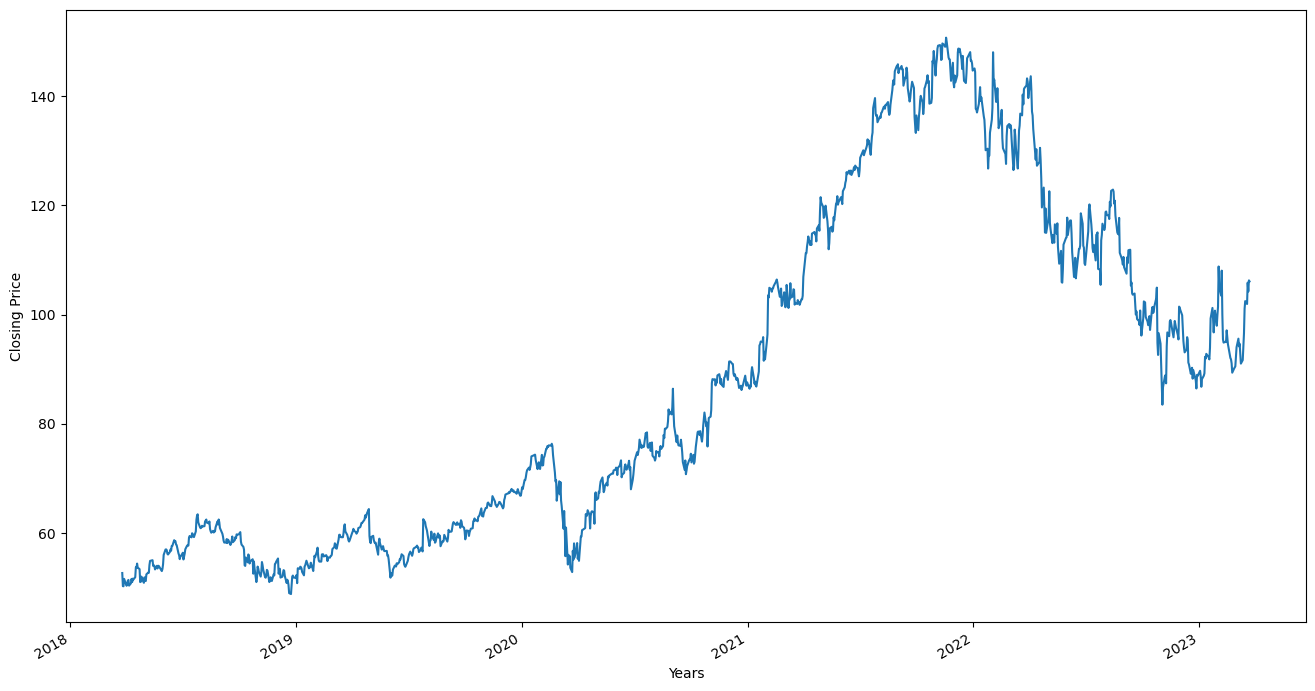

In [7]:
plt.figure(figsize = (16,9))
stock['Close'].plot()
plt.ylabel('Closing Price')
plt.xlabel('Years')
plt.show()

**Stock Volume Over the Years**

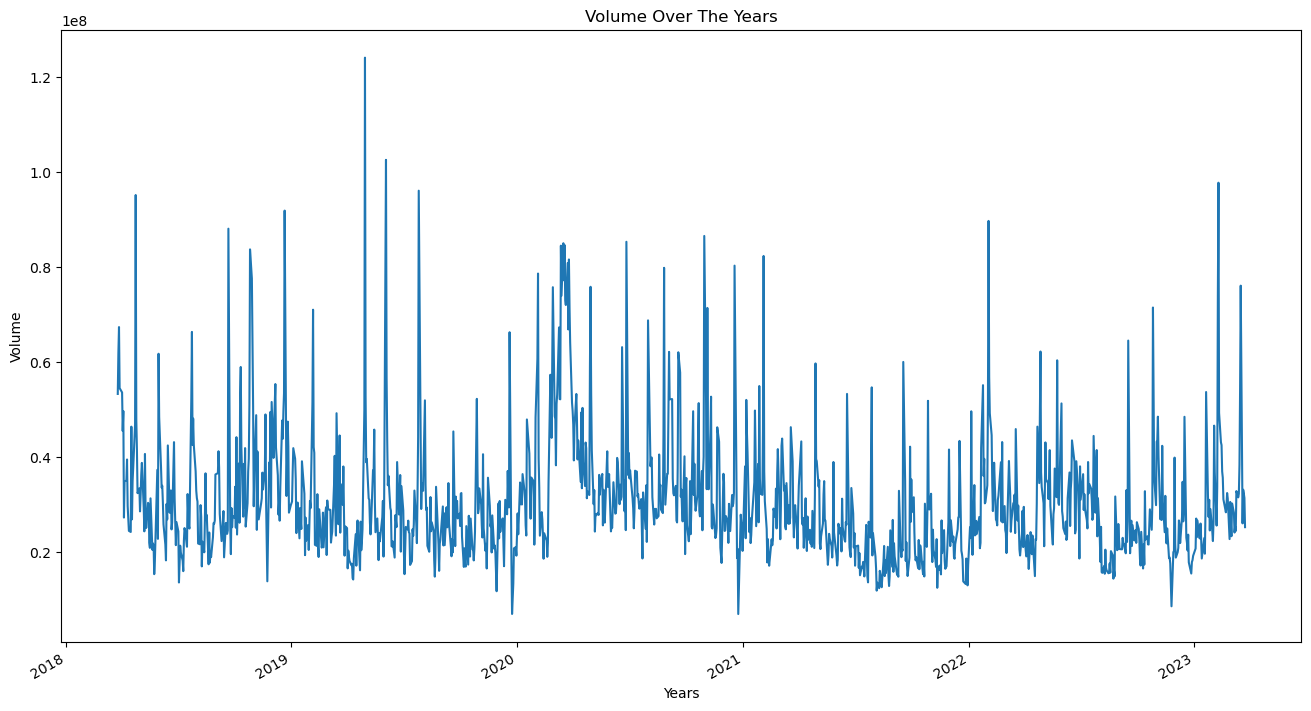

In [8]:
plt.figure(figsize=(16,9))
stock['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel('Years')
plt.title('Volume Over The Years')
plt.show()

**Moving Average of the Stock**

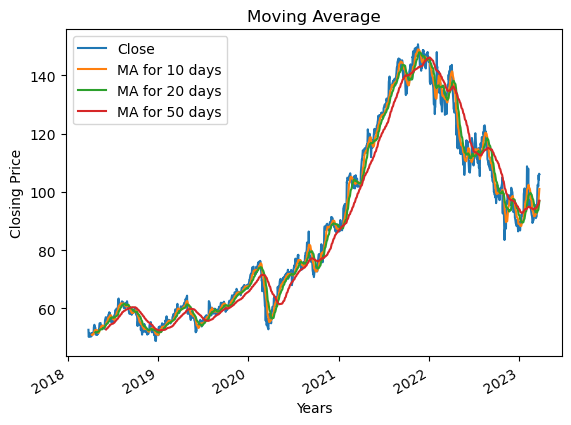

In [9]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    stock[column_name] = stock['Close'].rolling(ma).mean()


stock[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title('Moving Average')
plt.xlabel('Years')
plt.ylabel('Closing Price')
plt.show()


In [10]:
df = stock['Close']
df

Date
2018-03-26     52.660500
2018-03-27     50.255001
2018-03-28     50.228001
2018-03-29     51.589500
2018-04-02     50.323502
                 ...    
2023-03-20    101.930000
2023-03-21    105.839996
2023-03-22    104.220001
2023-03-23    106.260002
2023-03-24    106.059998
Name: Close, Length: 1259, dtype: float64

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
df = sc.fit_transform(np.array(df).reshape(-1,1))

In [12]:
training_size = int(len(df) * 0.7)
test_size = len(df) - training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [13]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
timestep = 100
X_train,y_train = create_dataset(train_data,timestep)
X_test,y_test = create_dataset(test_data,timestep)

In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [16]:
X_train.shape,y_train.shape

((780, 100, 1), (780,))

In [17]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 91,101
Trainable params: 91,101
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64)

Epoch 1/50
13/13 [==============================] - 12s 409ms/step - loss: 0.0452 - val_loss: 0.0228
Epoch 2/50
13/13 [==============================] - 3s 269ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 3/50
13/13 [==============================] - 4s 279ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 4/50
13/13 [==============================] - 3s 263ms/step - loss: 0.0013 - val_loss: 0.0069
Epoch 5/50
13/13 [==============================] - 3s 260ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 6/50
13/13 [==============================] - 3s 262ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 7/50
13/13 [==============================] - 3s 261ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 8/50
13/13 [==============================] - 3s 259ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 9/50
13/13 [==============================] - 4s 304ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 10/50
13/13 [==============================] - 3s 257ms/step - loss: 0.0012 - val_loss: 0.007

In [20]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

9/9 [==============================] - 1s 57ms/step


In [21]:
train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

In [22]:
len(test_data)

378

In [23]:
x_input = test_data[278:].reshape(1,-1)
x_input.shape

(1, 100)

In [24]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [25]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.55487]
101
1 day input [0.40912481 0.37546369 0.3403305  0.37183258 0.39096941 0.393521
 0.37870224 0.4451412  0.47026441 0.46339475 0.48979372 0.4924434
 0.48763469 0.48076511 0.46143204 0.47615264 0.49077508 0.47880231
 0.46555379 0.45760468 0.51658518 0.51491686 0.51050071 0.50107954
 0.47595632 0.45475869 0.44298217 0.4343461  0.43915481 0.46162828
 0.45632885 0.41599439 0.41265776 0.39587628 0.40058683 0.40667137
 0.38714206 0.40235331 0.38390351 0.36947731 0.39391349 0.39175453
 0.40127379 0.39155821 0.37251954 0.3861607  0.39244149 0.39675948
 0.426397   0.42296221 0.43169643 0.42541564 0.42168638 0.44258968
 0.49528939 0.51422991 0.49460243 0.47026441 0.49411179 0.50932304
 0.48223711 0.50107954 0.51638894 0.5887162  0.55358301 0.53640897
 0.58125774 0.50235529 0.45780093 0.4519127  0.45328662 0.4527959
 0.47389545 0.46094132 0.44926295 0.42433613 0.42188269 0.41471863
 0.397839   0.4051993  0.40716209 0.40922297 0.42688764 0.44366912
 0.4589786  0.4451412  0.44985182 0.4303

In [26]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [27]:
len(df)

1259

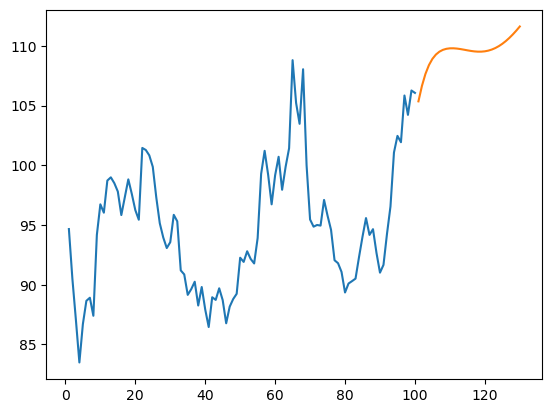

In [33]:
plt.plot(day_new,sc.inverse_transform(df[1159:]))
plt.plot(day_pred,sc.inverse_transform(lst_output))

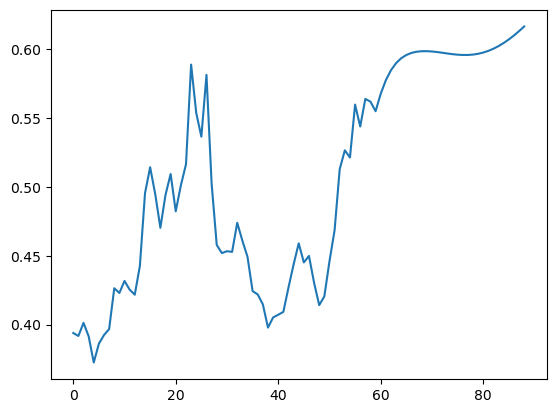

In [34]:
df3=df.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

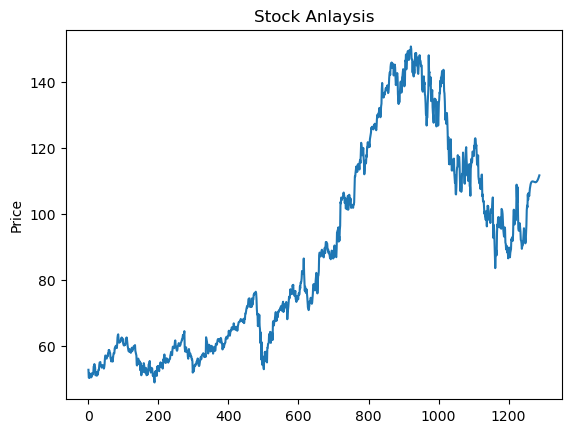

In [35]:
df3=sc.inverse_transform(df3).tolist()
plt.plot(df3)
plt.title('Stock Anlaysis')
plt.ylabel('Price')
plt.show()

In [31]:
stock.to_csv('data.csv')

In [37]:
model.save('mymodel.h5')